In [1]:
import helper
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn.feature_extraction.text import CountVectorizer

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer


from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, plot_roc_curve

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/sanderg/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Making adjustments to the the data frame as there were errors.

In [2]:
### Split the df into 2 columns

df = pd.read_csv('./data/SmsCollection.csv', sep='\t')
# df['label;text'].str.split(';')
df['Labels'] = df['label;text'].str.split(';', n=1, expand=True)[0]
df['label;text'] = df['label;text'].str.replace('ham;|spam;', '')
df.rename(columns = {'label;text':'Texts'}, inplace=True)

/tmp/ipykernel_14361/611920949.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  df['label;text'] = df['label;text'].str.replace('ham;|spam;', '')


In [3]:
# This should be now correct
df = df[['Labels', 'Texts']]
df.describe()

,Labels,Texts
count,5574,5574
unique,2,5171
top,ham,"Sorry, I'll call later"
freq,4827,30


In [4]:
df.head()

,Labels,Texts
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
# How many are spam and how many are ham
print(df['Labels'].value_counts())


ham     4827
spam     747
Name: Labels, dtype: int64


### Cleaning up the data

#### What snowball stemmer does: 
It reduced a word to its base root/word so that words of similar kind are under a common stem. EXAMPLE: 'care', 'cared' and 'caring' are all under the same stem of 'care'

#### What stopwords do:
The stopwords in nltk are the most common words in data. They are words that you do not want to use to describe the topic of your content. They are pre-defined and cannot be removed.

### Tokenisation:
So I read around and found that in text mining, tokenisation is process of breaking text into parts: below is the attempt at this process

In [6]:
# setting up the NLTK snowballstemmer to English
st = SnowballStemmer('english')
# setting the NLTK stopword list to English
stops = set(stopwords.words('english'))

"""Used list comprehensions that I saw online"""

# Changing to lower case and removing spaces 
df['Clean texts'] = df['Texts'].apply(lambda x: x.lower().strip())

# remove extra spaces in between
df['Clean texts'] = df['Clean texts'].apply(lambda x: re.sub(' +', ' ', x))

# remove punctuation
df['Clean texts'] = df['Clean texts'].apply(lambda x: re.sub('[^a-zA-Z]', ' ', x))

# remove stopwords and get the stem
df['Clean texts'] = df['Clean texts'].apply(lambda x: ' '.join(st.stem(text) for text in x.split() if text not in stops))

# Just in case this is needed, I split the Clean texts column into lists by word, but this causes and error with vectorisation
#df['Clean texts'] = df['Clean texts'].apply(lambda x: x.split(' '))
df

,Labels,Texts,Clean texts
0,ham,"Go until jurong point, crazy.. Available only ...",go jurong point crazi avail bugi n great world...
1,ham,Ok lar... Joking wif u oni...,ok lar joke wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entri wkli comp win fa cup final tkts st ...
3,ham,U dun say so early hor... U c already then say...,u dun say earli hor u c alreadi say
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah think goe usf live around though
...,...,...,...
5569,spam,This is the 2nd time we have tried 2 contact u...,nd time tri contact u u pound prize claim easi...
5570,ham,Will ü b going to esplanade fr home?,b go esplanad fr home
5571,ham,"Pity, * was in mood for that. So...any other s...",piti mood suggest
5572,ham,The guy did some bitching but I acted like i'd...,guy bitch act like interest buy someth els nex...


### Vectorisation:
The conventional process of dealing with Text data says that after cleaning the data, you can then proceed to Vectorisation: which is basically converting the text data into numerical data.
Here is the link: 
https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

In [7]:
# Labels to unique integer
df['label_num'] = df.Labels.map({'ham':0, 'spam':1})
df.head()

# Define X and y
X = df['Clean texts']
y = df.label_num
# print(X.shape)
# print(y.shape)

# Datasplit
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
# print(X_train.shape)
# print(X_test.shape)
# print(y_train.shape)
# print(y_test.shape)

# Instantiate vectorizer
vectorizer = CountVectorizer()
# Document term matrix train data
X_train_dtm = vectorizer.fit_transform(X_train)
# Document term matrix test data (using fitted vocabulary from training data!)
X_test_dtm = vectorizer.transform(X_test)
X_train_dtm

<4180x5360 sparse matrix of type '<class 'numpy.int64'>'
	with 33613 stored elements in Compressed Sparse Row format>

### Models and tests

mnb 0.97 accuracy with a standard deviation of 0.00
logreg 0.98 accuracy with a standard deviation of 0.00
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      3615
           1       0.88      0.94      0.91       565

    accuracy                           0.97      4180
   macro avg       0.93      0.96      0.95      4180
weighted avg       0.98      0.97      0.97      4180

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3615
           1       0.98      0.86      0.92       565

    accuracy                           0.98      4180
   macro avg       0.98      0.93      0.95      4180
weighted avg       0.98      0.98      0.98      4180



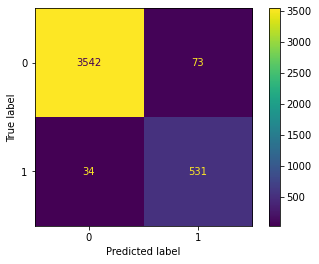

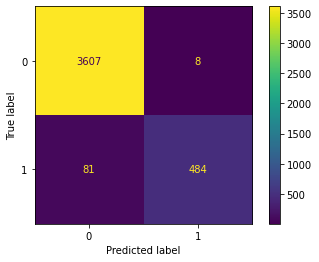

In [8]:
# Multinomial Naive Bayes, classifying with word counts 
mnb = MultinomialNB()
# Logistic regression
logreg = LogisticRegression(solver='liblinear')

# Cross-validate (stratified k fold) scores each model
scores_mnb = cross_val_score(mnb, X_train_dtm, y_train, cv=5)
scores_logreg = cross_val_score(logreg, X_train_dtm, y_train, cv=5)

print("mnb %0.2f accuracy with a standard deviation of %0.2f" % (scores_mnb.mean(), scores_mnb.std()))
print("logreg %0.2f accuracy with a standard deviation of %0.2f" % (scores_logreg.mean(), scores_logreg.std()))

pred_mnb = cross_val_predict(mnb, X_train_dtm, y_train, cv=5)
pred_logreg = cross_val_predict(logreg, X_train_dtm, y_train, cv=5)

print(classification_report(y_train, pred_mnb))
ConfusionMatrixDisplay.from_predictions(y_train, pred_mnb)

print(classification_report(y_train, pred_logreg))
ConfusionMatrixDisplay.from_predictions(y_train, pred_logreg)

(1394,)
(1394,)
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1212
           1       0.95      0.95      0.95       182

    accuracy                           0.99      1394
   macro avg       0.97      0.97      0.97      1394
weighted avg       0.99      0.99      0.99      1394

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1212
           1       0.99      0.90      0.94       182

    accuracy                           0.99      1394
   macro avg       0.99      0.95      0.97      1394
weighted avg       0.99      0.99      0.99      1394



/home/sanderg/.local/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/home/sanderg/.local/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


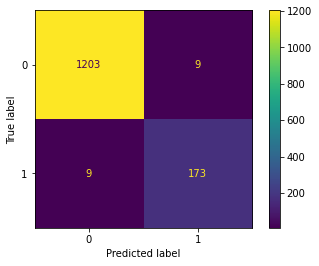

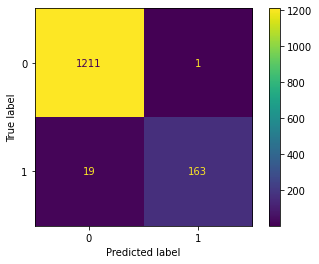

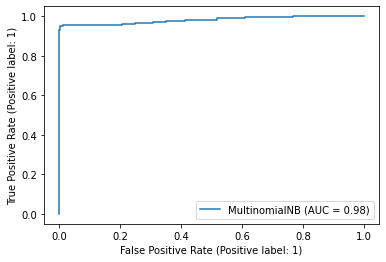

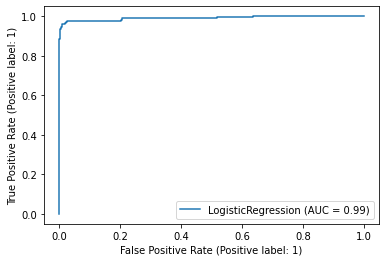

In [9]:
# Final results with testing data

# Fitting the models
mnb.fit(X_train_dtm, y_train)
logreg.fit(X_train_dtm, y_train)

# Predictions
mnb_pred = mnb.predict(X_test_dtm)
logreg_pred = logreg.predict(X_test_dtm)

print(mnb_pred.shape)
print(y_test.shape)

print(classification_report(y_test, mnb_pred))
ConfusionMatrixDisplay.from_predictions(y_test, mnb_pred)

print(classification_report(y_test, logreg_pred))
ConfusionMatrixDisplay.from_predictions(y_test, logreg_pred)

# ROC CURVES
plot_roc_curve(mnb, X_test_dtm, y_test)
plot_roc_curve(logreg, X_test_dtm, y_test)